In [1]:
import os

import polars as pl

import utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
num_trains = (50, 100)
num_tests = (50, 100, 200, 500)
accuracies_home_dir: str = "accuracies_from_paper"

In [3]:
dfs = []
for num_train in num_trains:
    for num_test in num_tests:
        dfs.append(
            utils.load_all_accuracies(
                os.path.join(accuracies_home_dir, f"m{num_train}"), num_test
            ).with_columns(
                pl.lit(num_train).alias("num_train"), pl.lit(num_test).alias("num_test")
            )
        )

In [4]:
accuracies_df: pl.DataFrame = pl.concat(dfs)

group = utils.subsample_group
accuracies_df = accuracies_df.sort(by=group)

In [5]:
accuracies_df = accuracies_df.with_columns(
    pretraining_boost=pl.col("extra") - pl.col("base"),
    evaluation_bias=pl.col("test") - pl.col("extra"),
)

# Grouped statistics

In [6]:
def sem(col: pl.Expr) -> pl.Expr:
    # ty https://github.com/pola-rs/polars/issues/6175#issuecomment-1416846104
    return col.std() / (col.count().sqrt())


accuracies_grouped = (  # aggregate subsamples into mean and SE
    accuracies_df.group_by(*group)
    .agg(
        pl.col("pretraining_boost").mean().name.suffix("_mean"),
        sem(pl.col("pretraining_boost")).name.suffix("_se"),
        pl.col("evaluation_bias").mean().name.suffix("_mean"),
        sem(pl.col("evaluation_bias")).name.suffix("_se"),
    )
    .sort(group)
)

In [7]:
accuracies_grouped

num_train,num_test,lm_type,dataset,pretraining_boost_mean,pretraining_boost_se,evaluation_bias_mean,evaluation_bias_se
i32,i32,str,str,f64,f64,f64,f64
50,50,"""bert""","""FRENK-hate-en""",-0.0264,0.009228,-0.0008,0.009551
50,50,"""bert""","""ag_news""",0.1006,0.0098,-0.0162,0.011223
50,50,"""bert""","""amazon_counterfactual_en""",0.0198,0.018692,0.0232,0.020512
50,50,"""bert""","""app_reviews""",0.1186,0.012834,0.007,0.015615
50,50,"""bert""","""blog_authorship_corpus""",-0.006,0.007001,0.0064,0.007638
…,…,…,…,…,…,…,…
100,500,"""gpt2""","""silicone""",0.0352,0.009397,-0.0095,0.005943
100,500,"""gpt2""","""trec""",0.0214,0.009417,-0.0009,0.00403
100,500,"""gpt2""","""tweets_hate_speech_detection""",0.0233,0.027941,-0.0056,0.019901


In [8]:
big_bias = 0.03

In [9]:
with pl.Config(tbl_rows=-1, tbl_width_chars=1_000):
    print(
        accuracies_grouped.filter(pl.col("evaluation_bias_mean") > big_bias)
        .sort(group)
        .select(group + ["evaluation_bias_mean", "evaluation_bias_se"])
    )

shape: (8, 6)
┌───────────┬──────────┬─────────┬──────────────────────────┬──────────────────────┬────────────────────┐
│ num_train ┆ num_test ┆ lm_type ┆ dataset                  ┆ evaluation_bias_mean ┆ evaluation_bias_se │
│ ---       ┆ ---      ┆ ---     ┆ ---                      ┆ ---                  ┆ ---                │
│ i32       ┆ i32      ┆ str     ┆ str                      ┆ f64                  ┆ f64                │
╞═══════════╪══════════╪═════════╪══════════════════════════╪══════════════════════╪════════════════════╡
│ 50        ┆ 200      ┆ bert    ┆ mtop_domain              ┆ 0.0318               ┆ 0.018115           │
│ 50        ┆ 500      ┆ bert    ┆ amazon_counterfactual_en ┆ 0.0504               ┆ 0.033422           │
│ 50        ┆ 500      ┆ bert    ┆ emo                      ┆ 0.0519               ┆ 0.03033            │
│ 50        ┆ 500      ┆ bert    ┆ financial_phrasebank     ┆ 0.0424               ┆ 0.025981           │
│ 100       ┆ 200      ┆ bert   

In [10]:
accuracies_grouped.filter(pl.col("evaluation_bias_mean") > big_bias)["dataset"].unique().sort().to_list()

['amazon_counterfactual_en',
 'craigslist_bargains',
 'emo',
 'financial_phrasebank',
 'mtop_domain',
 'trec']

In [11]:
with pl.Config(tbl_rows=-1, tbl_width_chars=1_000):
    print(
        accuracies_grouped.filter(pl.col("evaluation_bias_mean") > big_bias)
        .sort(group)
        .select(group + ["evaluation_bias_mean", "evaluation_bias_se"])
    )

shape: (8, 6)
┌───────────┬──────────┬─────────┬──────────────────────────┬──────────────────────┬────────────────────┐
│ num_train ┆ num_test ┆ lm_type ┆ dataset                  ┆ evaluation_bias_mean ┆ evaluation_bias_se │
│ ---       ┆ ---      ┆ ---     ┆ ---                      ┆ ---                  ┆ ---                │
│ i32       ┆ i32      ┆ str     ┆ str                      ┆ f64                  ┆ f64                │
╞═══════════╪══════════╪═════════╪══════════════════════════╪══════════════════════╪════════════════════╡
│ 50        ┆ 200      ┆ bert    ┆ mtop_domain              ┆ 0.0318               ┆ 0.018115           │
│ 50        ┆ 500      ┆ bert    ┆ amazon_counterfactual_en ┆ 0.0504               ┆ 0.033422           │
│ 50        ┆ 500      ┆ bert    ┆ emo                      ┆ 0.0519               ┆ 0.03033            │
│ 50        ┆ 500      ┆ bert    ┆ financial_phrasebank     ┆ 0.0424               ┆ 0.025981           │
│ 100       ┆ 200      ┆ bert   

Pretty sure they're all `bert` b/c it has much higher variance. Can test it out by
seeing which LM types pop up when reversing the direction:

In [12]:
with pl.Config(tbl_rows=-1, tbl_width_chars=1_000):
    print(
        accuracies_grouped.filter(pl.col("evaluation_bias_mean") < -big_bias)
        .sort(group)
        .select(group + ["evaluation_bias_mean", "evaluation_bias_se"])
    )

shape: (7, 6)
┌───────────┬──────────┬─────────┬──────────────────────────────┬──────────────────────┬────────────────────┐
│ num_train ┆ num_test ┆ lm_type ┆ dataset                      ┆ evaluation_bias_mean ┆ evaluation_bias_se │
│ ---       ┆ ---      ┆ ---     ┆ ---                          ┆ ---                  ┆ ---                │
│ i32       ┆ i32      ┆ str     ┆ str                          ┆ f64                  ┆ f64                │
╞═══════════╪══════════╪═════════╪══════════════════════════════╪══════════════════════╪════════════════════╡
│ 50        ┆ 200      ┆ bert    ┆ tweets_hate_speech_detection ┆ -0.0593              ┆ 0.024333           │
│ 50        ┆ 500      ┆ bert    ┆ mtop_domain                  ┆ -0.0355              ┆ 0.021482           │
│ 50        ┆ 500      ┆ bert    ┆ tweets_hate_speech_detection ┆ -0.0639              ┆ 0.04675            │
│ 100       ┆ 100      ┆ bert    ┆ craigslist_bargains          ┆ -0.0371              ┆ 0.016537         

In [13]:
with pl.Config(tbl_rows=-1):
    print(
        accuracies_grouped.group_by("dataset")
        .agg(
            pl.col("pretraining_boost_mean").mean(),
            pl.col("evaluation_bias_mean").mean(),
        )
        .sort("pretraining_boost_mean", descending=True)
    )

shape: (25, 3)
┌────────────────────────────────┬────────────────────────┬──────────────────────┐
│ dataset                        ┆ pretraining_boost_mean ┆ evaluation_bias_mean │
│ ---                            ┆ ---                    ┆ ---                  │
│ str                            ┆ f64                    ┆ f64                  │
╞════════════════════════════════╪════════════════════════╪══════════════════════╡
│ mtop_domain                    ┆ 0.142169               ┆ -0.003463            │
│ app_reviews                    ┆ 0.1134125              ┆ 0.002575             │
│ emo                            ┆ 0.098594               ┆ -0.0018              │
│ tweets_hate_speech_detection   ┆ 0.081575               ┆ -0.008256            │
│ amazon_counterfactual_en       ┆ 0.078344               ┆ 0.009306             │
│ ag_news                        ┆ 0.078325               ┆ -0.001613            │
│ silicone                       ┆ 0.049681               ┆ -0.001281   

In [14]:
with pl.Config(tbl_rows=-1):
    print(
        accuracies_grouped.group_by("dataset")
        .agg(  # across m, n, lm_type
            pl.col("pretraining_boost_mean").mean(),
            (pl.col("pretraining_boost_mean") < 0).mean().alias("frac_boost_lt_0"),
        )
        .filter(pl.col("pretraining_boost_mean") < 0)
        .sort("pretraining_boost_mean")
    )

shape: (2, 3)
┌────────────────────────┬────────────────────────┬─────────────────┐
│ dataset                ┆ pretraining_boost_mean ┆ frac_boost_lt_0 │
│ ---                    ┆ ---                    ┆ ---             │
│ str                    ┆ f64                    ┆ f64             │
╞════════════════════════╪════════════════════════╪═════════════════╡
│ blog_authorship_corpus ┆ -0.009588              ┆ 0.625           │
│ movie_rationales       ┆ -0.004675              ┆ 0.6875          │
└────────────────────────┴────────────────────────┴─────────────────┘


In [15]:
with pl.Config(tbl_rows=-1):
    print(
        accuracies_grouped.group_by("dataset")
        .agg(  # across m, n, lm_type
            pl.col("evaluation_bias_mean").mean(),
            (pl.col("evaluation_bias_mean") > 0).mean().alias("frac_bias_gt_0"),
        )
        .filter(pl.col("evaluation_bias_mean") > 0)
        .sort("evaluation_bias_mean", descending=True)
    )

shape: (12, 3)
┌────────────────────────────────┬──────────────────────┬────────────────┐
│ dataset                        ┆ evaluation_bias_mean ┆ frac_bias_gt_0 │
│ ---                            ┆ ---                  ┆ ---            │
│ str                            ┆ f64                  ┆ f64            │
╞════════════════════════════════╪══════════════════════╪════════════════╡
│ amazon_counterfactual_en       ┆ 0.009306             ┆ 0.5625         │
│ financial_phrasebank           ┆ 0.007406             ┆ 0.6875         │
│ trec                           ┆ 0.002819             ┆ 0.5            │
│ app_reviews                    ┆ 0.002575             ┆ 0.6875         │
│ clickbait_notclickbait_dataset ┆ 0.0023625            ┆ 0.625          │
│ craigslist_bargains            ┆ 0.0014               ┆ 0.6875         │
│ climate_fever                  ┆ 0.001088             ┆ 0.5625         │
│ emotion                        ┆ 0.001088             ┆ 0.6875         │
│ blog_aut

# Correlations

This is an interesting analysis proposed by [Eilon](https://github.com/eilonrtzur). Does
the subsample cause consistent biases? If so, maybe it's not so bad that we only use a
single subsample to compare models. If not, it's bad. The data is really noisy, but
maybe we might see a positive correlation on average.

In [16]:
from functools import partial

from scipy import stats
import seaborn as sns
from tqdm.auto import tqdm

In [17]:
def corr_bt_lm_types(df_group: pl.DataFrame, shuffle: bool = False) -> pl.DataFrame:
    def df_lm_type(lm_type: str) -> pl.DataFrame:
        df_lm = df_group.filter((pl.col("lm_type") == lm_type))
        if shuffle:  # for permuation test
            return df_lm.sample(fraction=1, shuffle=True, seed=None)
        else:
            # Verified that this isn't necessary:
            # return df_lm.sort("subsample_idx")
            return df_lm

    bert = df_lm_type("bert")
    gpt2 = df_lm_type("gpt2")
    return pl.DataFrame(
        {
            "num_train": df_group["num_train"][0],
            "num_test": df_group["num_test"][0],
            "dataset": df_group["dataset"][0],
            "pb": stats.spearmanr(
                bert["pretraining_boost"], gpt2["pretraining_boost"]
            ).statistic,
            "eb": stats.spearmanr(
                bert["evaluation_bias"], gpt2["evaluation_bias"]
            ).statistic,
        }
    )

In [18]:
corr = accuracies_df.group_by("num_train", "num_test", "dataset").map_groups(
    partial(corr_bt_lm_types, shuffle=False)
)

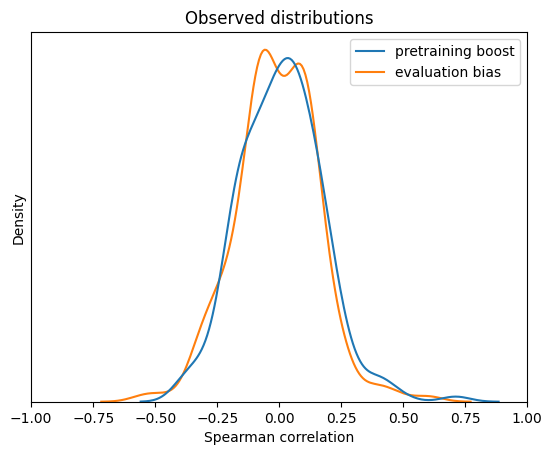

In [19]:
ax = sns.kdeplot(
    corr.select("pb", "eb")
    .rename({"pb": "pretraining boost", "eb": "evaluation bias"})
    .to_pandas()
)
ax.set_xlim(-1, 1)
ax.set_xlabel("Spearman correlation")
ax.set_yticks([])
ax.set_ylabel("Density")
ax.set_title("Observed distributions");

In [20]:
permutations = []
for i in tqdm(range(10)):
    permutations.append(
        accuracies_df.group_by("num_train", "num_test", "dataset", maintain_order=True)
        .map_groups(partial(corr_bt_lm_types, shuffle=True))
        .rename({"pb": f"pb{i}", "eb": f"eb{i}"})
    )
df_permuations: pl.DataFrame = pl.concat(permutations, how="align")
del permutations

  0%|          | 0/10 [00:00<?, ?it/s]

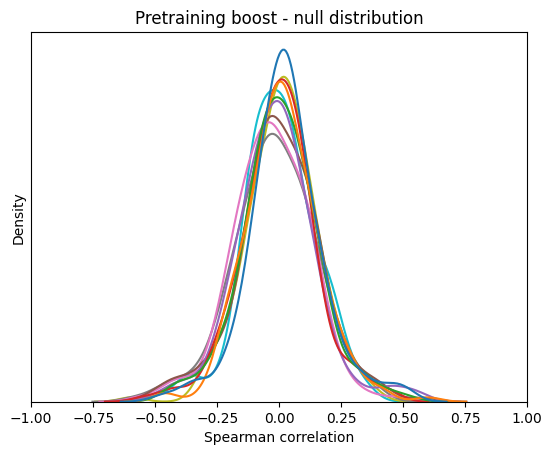

In [21]:
ax = sns.kdeplot(df_permuations.select(pl.selectors.starts_with("pb")), legend=False)
ax.set_xlabel("Spearman correlation")
ax.set_xlim(-1, 1)
ax.set_yticks([])
ax.set_ylabel("Density")
ax.set_title("Pretraining boost - null distribution");

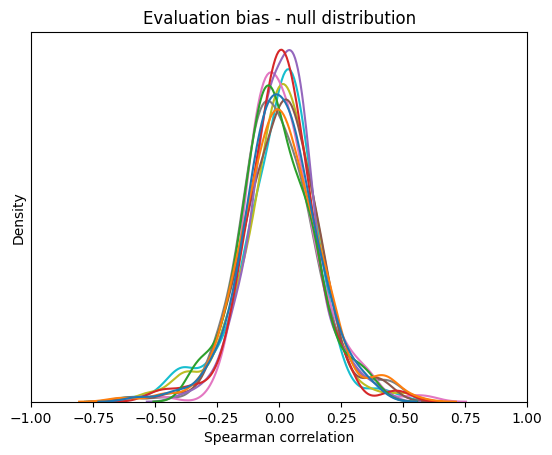

In [22]:
ax = sns.kdeplot(df_permuations.select(pl.selectors.starts_with("eb")), legend=False)
ax.set_xlabel("Spearman correlation")
ax.set_xlim(-1, 1)
ax.set_yticks([])
ax.set_ylabel("Density")
ax.set_title("Evaluation bias - null distribution");